In [33]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
import os
folder='/gladstone/engelhardt/lab/hvu/RNA_rates/elong_rates/pair_end_reads/constant/'
result_fn_list=glob.glob(folder+'/*/pred_h.csv.gz')

def calculate_weight(row):
    # if row ends at infinity, set the weight to max(0, 1-row['start']/row['gene_length'])
    if np.isinf(row['end']):
        return max(0, 1-row['start']/row['gene_length'])
    else:
        return (row['end'] - row['start'])/row['gene_length']
    

def read_one_result(fn, method = 'simple', min_h = 0, max_h = 20):
    result_df = pd.read_csv(fn, header = 0, index_col=None, sep ='\t')
    result_df = result_df[result_df['solver']==method]
    subfolder  = fn.split('/')[-2]
    subfolder_idx = int(subfolder.split('_')[-1])
    # if values are beyond [0, 20], set them as np.nan
    result_df['pred_h'] = result_df['pred_h'].apply(lambda x: x if min_h<=x<=max_h else np.nan)
    gtf_fn = os.path.join(folder, subfolder, 'gtf_df.csv')
    gtf_df = pd.read_csv(gtf_fn, header = 0, index_col=None, sep = '\t')
    result_df['subfolder_idx'] = subfolder_idx
    gene_length = gtf_df[gtf_df['feature']=='PAS']['end'].values[0]  # only for this evaluation that we consider RTR to be the gene length
    result_df['gene_length'] = gene_length/1000
    result_df['time_all_gene'] = gene_length/1000/result_df['true_h']
    # for this result table, calculate the weighted absD of (pred_h and true_h), and weighted difference (1, pred_h/true_h)
    # weight = (end-start)/gene_length
    result_df['weight'] = result_df.apply(calculate_weight, axis = 1)
    result_df['absD'] = np.abs(result_df['pred_h']-result_df['true_h'])
    result_df['ratioD'] = np.abs(1-result_df['pred_h']/result_df['true_h'])
    result_df['run_idx'] = (result_df['end']==np.inf).cumsum()  # this it to reconstruct the run_idx (corresponding to different runs of the algorithms that we calculate pred_h with different bin size)
    # for each run_idx, find the pred_h that has the highest absD
    result_df['worst_idx'] = result_df.groupby('run_idx')['absD'].transform(lambda x: x.idxmax())
    # for each row, replace absD that is nan with the absD of the worst_idx
    result_df['absD'] = result_df['absD'].fillna(result_df['worst_idx'].map(result_df['absD']))
    result_df['weighted_absD'] = result_df['weight']*result_df['absD']
    result_df['ratioD'] = result_df['ratioD'].fillna(result_df['worst_idx'].map(result_df['ratioD']))
    result_df['weighted_ratioD'] = result_df['weight']*result_df['ratioD']
    # for the last row of result_df, we will keep them as run_dix-1, this is just a quirky thing about the data
    result_df.loc[result_df.index[-1], 'run_idx'] = result_df['run_idx'].max()-1
    return result_df

method = 'bayesian_RBF'
result_df_list = map(lambda x: read_one_result(x, method=method), result_fn_list)
result_df = pd.concat(result_df_list)
result_df.reset_index(inplace=True, drop=True)

/tmp/ipykernel_3095302/774351268.py:37: FutureWarning: The behavior of Series.idxmax with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
  result_df['worst_idx'] = result_df.groupby('run_idx')['absD'].transform(lambda x: x.idxmax())
/tmp/ipykernel_3095302/774351268.py:37: FutureWarning: The behavior of Series.idxmax with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
  result_df['worst_idx'] = result_df.groupby('run_idx')['absD'].transform(lambda x: x.idxmax())
/tmp/ipykernel_3095302/774351268.py:37: FutureWarning: The behavior of Series.idxmax with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
  result_df['worst_idx'] = result_df.groupby('run_idx')['absD'].transform(lambda x: x.idxmax())
/tmp/ipykernel_3095302/774351268.py:37: FutureWarning: The behavior of Series.idxmax with all-NA values, or any-NA and skipna=F

In [34]:
# now we will summarize the results
# group by subfolder_idx and run_idx
summ_df = result_df.groupby(['subfolder_idx', 'run_idx', 'gene_length']).agg({'weighted_absD':'sum', 'weighted_ratioD':'sum', 'time_all_gene':'mean', 'absD':'mean', 'ratioD': 'mean'})
summ_df.reset_index(inplace=True)
h_bin_length=[200, 300, 400, 500, 600, 700, 800, 900, 1000, 1250, 1500, 1750, 2000]
summ_df['h_bin'] = summ_df['run_idx'].apply(lambda x: h_bin_length[int(x)]/1000)
summ_df['time_all_gene'] = summ_df['time_all_gene'].astype(int)

In [35]:
# save summ_df to excel
output_fn = os.path.join(folder, f'summ_{method}_df.xlsx')
summ_df.to_excel(output_fn, index=False)
summ_df.to_csv(output_fn.replace('xlsx', 'csv.gz'), index=False, compression='gzip', sep='\t')

AttributeError: 'numpy.ndarray' object has no attribute 'savefig'

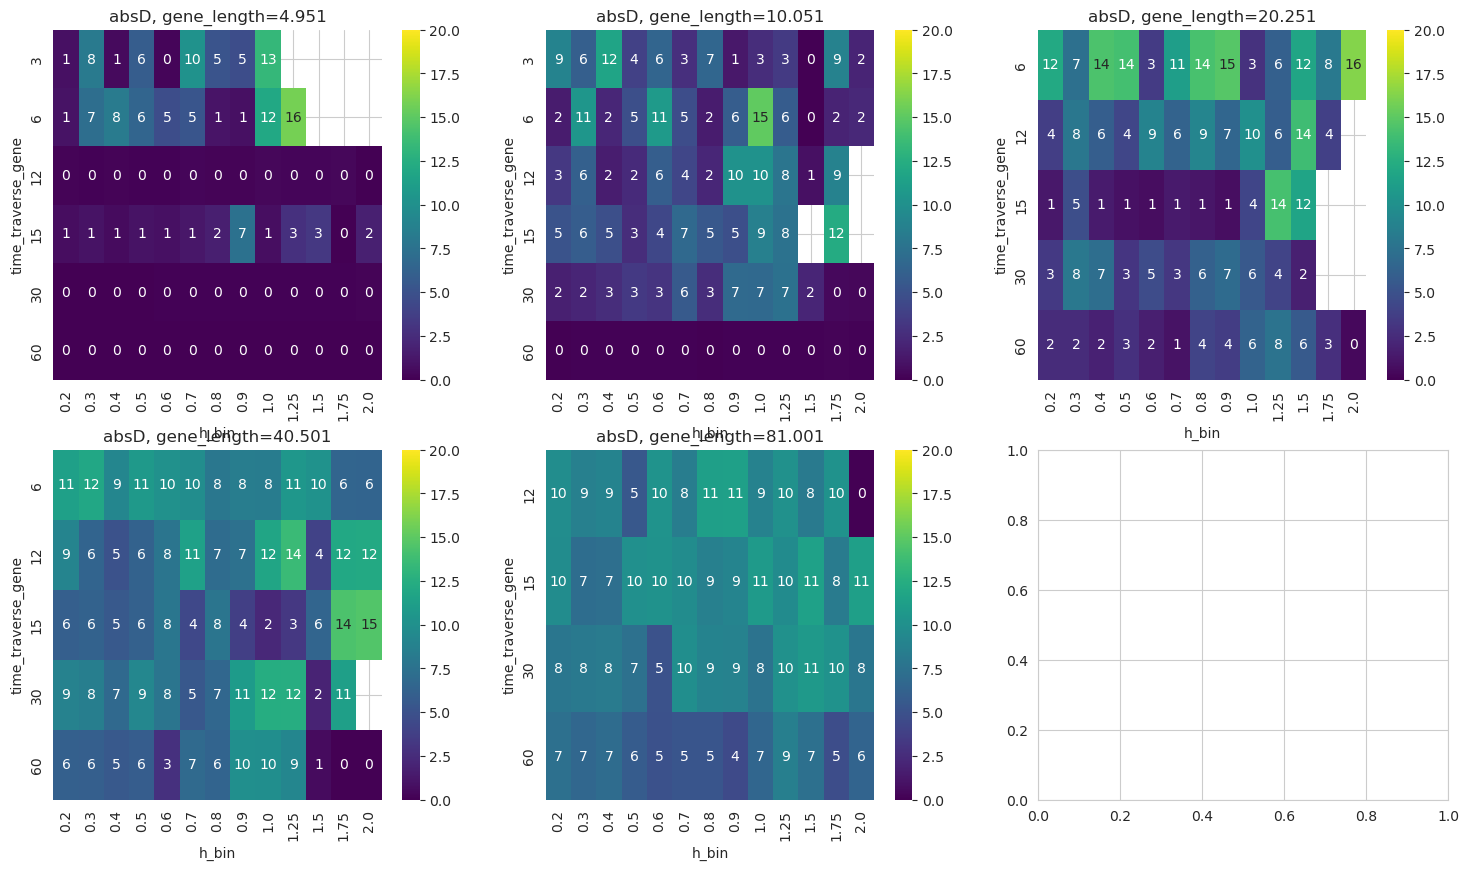

In [38]:
# plot the heatmap: x axis is h_bin, y_axis is time_all_gene, color is weighted_absD
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
# Create the heatmap, different subplots corresponding to different values of gene_length, and we draw heatmaps with x-axis being h_bin and y-axis being time_along_gene
axes, fig = plt.subplots(2, 3, figsize=(18, 10))
uniq_gene_length = summ_df['gene_length'].unique()
eval_metric = 'absD'
for i, gene_length in enumerate(uniq_gene_length):
    row = i//3
    col = i%3
    ax = fig[row, col]
    plot_df = summ_df[summ_df['gene_length']==gene_length]
    heatmap_data = plot_df.pivot(columns='h_bin', index='time_all_gene', values=eval_metric)
    sns.heatmap(heatmap_data, cmap="viridis", annot=True, fmt=".0f", vmin=0, vmax=20, ax=ax)
    ax.set_xlabel('h_bin')
    ax.set_ylabel('time_traverse_gene')
    ax.set_title(f'{eval_metric}, gene_length={gene_length}')
fig.savefig(os.path.join(folder, f'byGeneLength_{method}_{eval_metric}.png'))
# plot_df = summ_df.groupby(['h_bin', 'time_all_gene']).agg({'weighted_absD':'mean'}).reset_index()
# heatmap_data = plot_df.pivot(columns='h_bin', index='time_all_gene', values='weighted_absD')
# 
# 
# plt.figure(figsize=(10, 8))
# sns.heatmap(heatmap_data, cmap="viridis", annot=True, fmt=".1f", vmin=0, vmax=20)
# 
# plt.xlabel('h_bin')
# plt.ylabel('time_traverse_gene')
# 
# plt.title('Heatmap of weighted_absD')
plt.show()

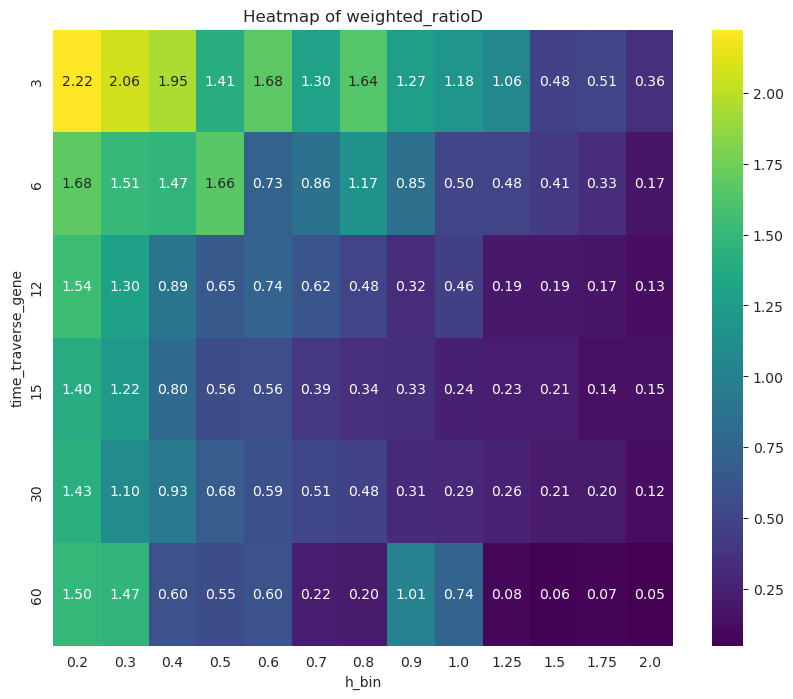

In [55]:
# plot the heatmap: x axis is h_bin, y_axis is time_all_gene, color is weighted_absD
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
plot_df = summ_df.groupby(['h_bin', 'time_all_gene']).agg({'weighted_ratioD':'mean'}).reset_index()
heatmap_data = plot_df.pivot(columns='h_bin', index='time_all_gene', values='weighted_ratioD')

# Create the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(heatmap_data, cmap="viridis", annot=True, fmt=".2f")
plt.xlabel('h_bin')
plt.ylabel('time_traverse_gene')

plt.title('Heatmap of weighted_ratioD')
plt.show()